In [1]:
import shapely
import shapely.wkt
import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import numpy as np
import os
import scipy.stats
import seaborn as sns
warnings.filterwarnings("ignore")

from tqdm import tqdm
from shapely import wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from modules.transform import calculate_distance_matrix, od_matrix_to_links
from modules.transform import load_graph_geometry, get_accessibility_isochrone
from modules.transform import dfs2nx
from modules.ilp_solver import ilp_distribute
from modules.dcgm import dcgm_distribute
from modules.dcgm_custom import custom_dcgm_distribute


from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [5]:
# territorial units
municipalities = gpd.read_file("data/mo.geojson") # proj EPSG:32636
blocks = gpd.read_file("data/blocks.geojson") # proj EPSG:32636

# houses and facilities
houses = gpd.read_file("data/houses.geojson").set_index("internal_id") # proj EPSG:32636
facilities = gpd.read_file("data/facilities_kindergartens.geojson").set_index("internal_id") # proj EPSG:32636

houses = houses.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)
facilities = facilities.sjoin(municipalities).rename(columns={"id": "municipality_id"}).drop(["index_right"], axis=1)

# road network
network = nx.read_graphml("data/road_network.graphml", node_type=int)
road_network = load_graph_geometry(network, node=True)

In [6]:
houses.head()

,demand,x,y,geometry,municipality_id
internal_id,,,,,
112224,31.0,355274.215073,6.646370e+06,POINT (355274.21507 6646370.02189),40
112225,12.0,355549.172648,6.649194e+06,POINT (355549.17265 6649194.43095),39
112226,2.0,361075.475929,6.650771e+06,POINT (361075.47593 6650770.91801),45
112227,11.0,355919.101248,6.646158e+06,POINT (355919.10125 6646157.60580),40
112229,3.0,357696.090731,6.654547e+06,POINT (357696.09073 6654546.84407),41


In [7]:
facilities.head()

,capacity,geometry,municipality_id
internal_id,,,
146052,180,POINT (355926.257 6646348.659),40
146061,213,POINT (314265.317 6678375.478),3
146102,475,POINT (363322.829 6624261.086),6
146169,632,POINT (319182.265 6655007.416),8
146329,133,POINT (357062.830 6618944.111),5


#### **Disatnce Matrix (DM)**

In [8]:
# calculate distance matrix based on OSM road network
DM = calculate_distance_matrix(network, houses, facilities)

100%|██████████| 21464/21464 [00:04<00:00, 5284.82it/s]


#### **Integer Linear Programming (ILP) and Doubly-Constrained Gravity Model (DCGM)**

In [9]:
# model population-facilties interactions with ILP

kindergarten_ca = 600 # kindergarten catchment area
DM = calculate_distance_matrix(network, houses, facilities)
OD_ILP = ilp_distribute(houses, facilities, DM, selection_range=kindergarten_ca)

100%|██████████| 21464/21464 [00:03<00:00, 5463.85it/s]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [ ]:
# model population-facilties interactions with classic DCGM
# ! DOESN'T CONVERGE

OD_DCGM = dcgm_distribute(houses, facilities, DM)

ipfn converged: convergence_rate not updating or below rate_tolerance
Residual demand: 227.0 Residual capacity: 17121.0
ipfn converged: convergence_rate not updating or below rate_tolerance
Residual demand: 223.0 Residual capacity: 17117.0
ipfn converged: convergence_rate not updating or below rate_tolerance
Residual demand: 223.0 Residual capacity: 17117.0
The matrix balancing doesn't converge.


In [10]:
#  model population-facilties interactions with custom DCGM

kindergarten_ca = 600 # kindergarten catchment area
b=0

OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, kindergarten_ca, p=b)

100%|██████████| 9/9 [00:26<00:00,  2.93s/it]

Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


In [11]:
# merge results into dfs

dist = kindergarten_ca

houses["supported_demand_ilp"] = OD_ILP[DM <= dist][houses.index].fillna(0).sum()
houses["supported_demand_dcgm"] = OD_СDCGM[DM <= dist][houses.index].fillna(0).sum()

houses["provision_ilp"] = houses["supported_demand_ilp"] / houses["demand"]
houses["provision_dcgm"] = houses["supported_demand_dcgm"] / houses["demand"]

houses["left_demand_ilp"] = houses["demand"] - houses["supported_demand_ilp"]
houses["left_demand_dcgm"] = houses["demand"] - houses["supported_demand_dcgm"]

facilities["left_capacity_ilp"] = facilities["capacity"] - OD_ILP[DM <= dist].fillna(0).sum(1)
facilities["left_capacity_dcgm"] = facilities["capacity"] - OD_СDCGM[DM <= dist].fillna(0).sum(1)

# aggregate assessments into municipalities
houses_aggr = houses.groupby(["municipality_id"])[['supported_demand_ilp', 'supported_demand_dcgm', 'demand']].sum()
municipalities = municipalities.join(
    (houses_aggr["supported_demand_ilp"] / houses_aggr["demand"]).rename("provision_ilp"), on="id")
municipalities = municipalities.join(
    (houses_aggr["supported_demand_dcgm"] / houses_aggr["demand"]).rename("provision_dcgm"), on="id")

edges_ilp = od_matrix_to_links(OD_ILP, DM, houses, facilities)
edges_dcgm = od_matrix_to_links(OD_СDCGM, DM, houses, facilities)

100%|██████████| 21464/21464 [00:30<00:00, 698.56it/s]


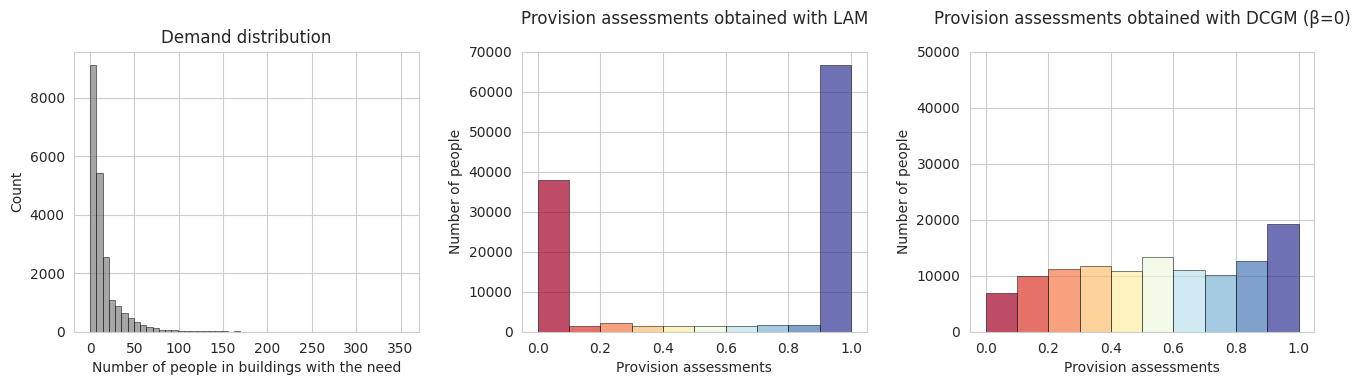

In [18]:
# plot provision assessments distribution

def set_color_map(bins, patches, color_palette):
    cm = plt.cm.get_cmap(color_palette)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

dist = kindergarten_ca
houses_loc = houses
facilities_loc = facilities

p_ilp = houses_loc.loc[houses_loc.index.repeat(houses_loc.demand)]["provision_ilp"]
p_dcgm = houses_loc.loc[houses_loc.index.repeat(houses_loc.demand)]["provision_dcgm"]

fig = plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

n, bins, patches = ax1.hist(houses_loc["demand"], 50,  alpha = 0.7, color='grey', edgecolor='black', linewidth=0.5)
ax1.set_xlabel("Number of people in buildings with the need")
ax1.set_ylabel("Count")
ax1.set_title("Demand distribution")

ax2_n, bins, patches = ax2.hist(p_ilp[p_ilp != p_dcgm], 10, alpha = 0.7, edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax2.set_xlabel("Provision assessments")
ax2.set_ylabel("Number of people")
ax2.set_title("Provision assessments obtained with LAM", pad=20)

ax3_n, bins, patches = ax3.hist(p_dcgm[p_ilp != p_dcgm], 10, alpha = 0.7, edgecolor='black', linewidth=0.5)
set_color_map(bins, patches, "RdYlBu")
ax3.set_yticks(list(range(0, 60000, 10000)))
ax3.set_xlabel("Provision assessments")
ax3.set_ylabel("Number of people")
ax3.set_title(f"Provision assessments obtained with DCGM (β={b})", pad=20)

plt.show()

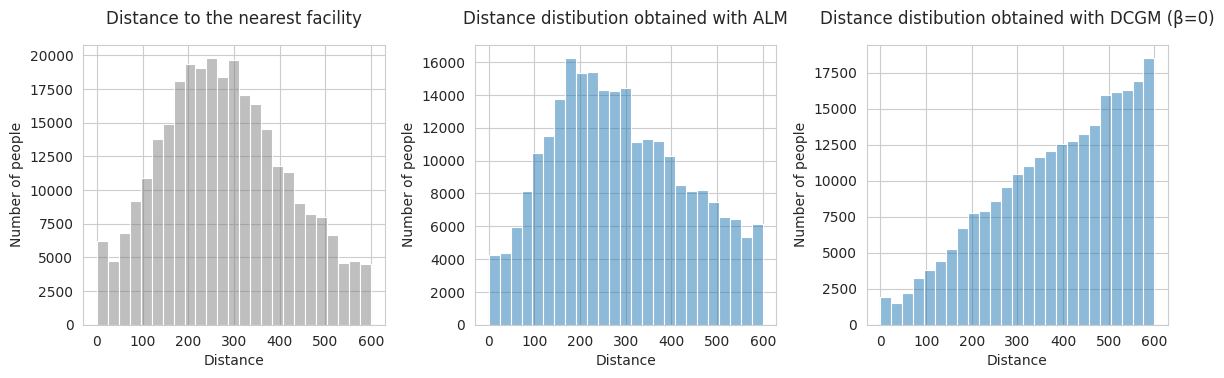

In [21]:
#plot distance distribution 

dist = kindergarten_ca
houses_loc = houses 

fig = plt.figure(figsize=(14, 8))
plt.subplots_adjust(wspace=0.3)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

distances_ilp = DM[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
distances_ilp = distances_ilp[~np.isnan(distances_ilp)]
flows_ilp = OD_ILP[OD_ILP > 0][houses_loc.index].to_numpy().flatten()
flows_ilp = flows_ilp[~np.isnan(flows_ilp)]

distances = DM.min().loc[houses_loc.index]
demand = houses["demand"].loc[houses_loc.index]

f_dist_nearest = pd.DataFrame({
    "distance": list(distances[distances <= dist]), 
    "demand": demand[distances <= dist]
    })
f_dist_dcgm = pd.DataFrame({
    "distance": distances_dcgm[distances_dcgm<=dist], 
    "flows":flows_dcgm[distances_dcgm<=dist]
    })
f_dist_ilp = pd.DataFrame({
    "distance": distances_ilp[distances_ilp<=dist], 
    "flows":flows_ilp[distances_ilp<=dist]
    })

sns.histplot(data=f_dist_nearest, x="distance", bins=25, alpha = 0.5, ax=ax1, kde=False, color="gray", weights='demand')
ax1.set_title("Distance to the nearest facility", pad=15)
ax1.set_xlabel("Distance")
ax1.set_ylabel("Number of people")

sns.histplot(data=f_dist_ilp, x="distance", bins=25, alpha = 0.5, ax=ax2, kde=False, weights='flows')
ax2.set_title("Distance distibution obtained with ALM", pad=15)
ax2.set_xlabel("Distance")
ax2.set_ylabel("Number of people")

sns.histplot(data=f_dist_dcgm, x="distance", bins=25, alpha = 0.5, ax=ax3, kde=False, weights='flows')
ax3.set_title(f"Distance distibution obtained with DCGM (β={b})", pad=15)
ax3.set_xlabel("Distance")
ax3.set_ylabel("Number of people")


plt.show()

100%|██████████| 9/9 [00:55<00:00,  6.18s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:57<00:00,  6.39s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:51<00:00,  5.70s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:49<00:00,  5.54s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:51<00:00,  5.67s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


100%|██████████| 9/9 [00:52<00:00,  5.83s/it]


Flows have been distributed.
Population left: 14753.0
Capacities left: 0.0


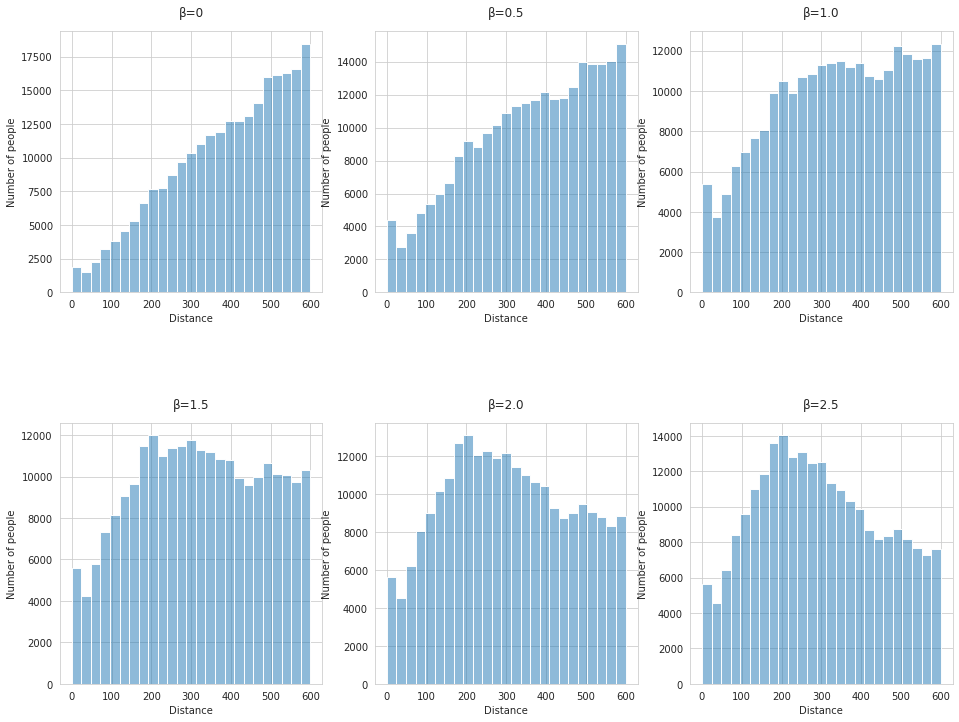

In [106]:
# plot distance distribution with varying p 

fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

b = 0

houses_loc = houses
for i in range(1, 7):
    OD_СDCGM = custom_dcgm_distribute(houses, facilities, DM, 600, p=b)

    distances_dcgm = DM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    distances_dcgm = distances_dcgm[~np.isnan(distances_dcgm)]
    flows_dcgm = OD_СDCGM[OD_СDCGM > 0][houses_loc.index].to_numpy().flatten()
    flows_dcgm = flows_dcgm[~np.isnan(flows_dcgm)]

    f_dist_dcgm = pd.DataFrame({
        "distance": distances_dcgm[distances_dcgm<=dist], 
        "flows":flows_dcgm[distances_dcgm<=dist]
        })

    sns.histplot(
        data=f_dist_dcgm, x="distance", bins=50, alpha = 0.5, 
        ax=locals()["ax" + str(i)], kde=False, weights='flows'
        )
    locals()["ax" + str(i)].set_title(f"β={str(b)}", pad=15)
    locals()["ax" + str(i)].set_xlabel("Distance")
    locals()["ax" + str(i)].set_ylabel("Number of people")

    b += 0.5

plt.show()

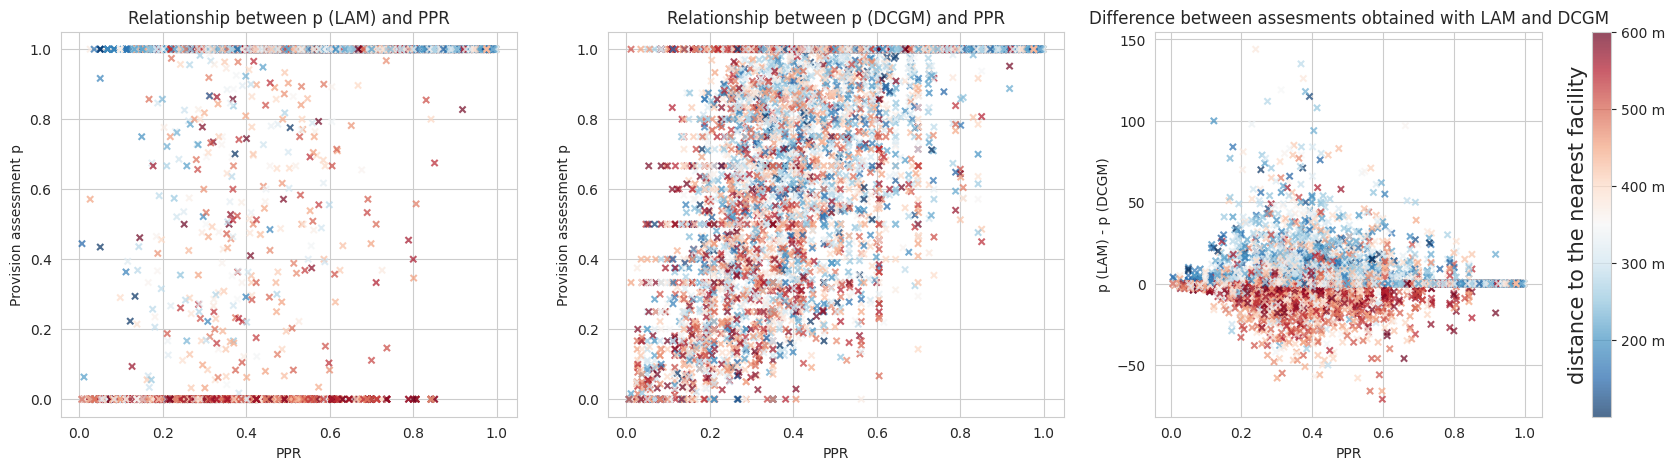

In [23]:
# Plot population-to-provider ratio within overlapping catchement areas

diff = houses["left_demand_ilp"] - houses["left_demand_dcgm"]

dm = (DM <= dist)
demand_around = dm.apply(lambda x: houses['demand'][dm.loc[facilities["capacity"][x].index].any()].sum())
sum_capacity = dm.apply(lambda x: facilities["capacity"][x].sum())
ratio = sum_capacity / demand_around

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
color_palette = plt.cm.get_cmap("RdBu_r")
distances = list(DM.min()[ratio < 1])
color_pointer = [i / max(distances) for i in distances]

ax1.set_xlabel("PPR")
ax1.set_ylabel("Provision assessment p")
a = ax1.scatter(
     ratio[ratio < 1], 
     houses["provision_ilp"][ratio < 1], 
     c=color_pointer, 
     cmap=color_palette, 
     s=20, 
     marker="x", 
     alpha=0.7
     )

ax1.set_title("Relationship between p (LAM) and PPR")
ax1.tick_params(labelsize = 10)

ax2.set_xlabel("PPR")
ax2.set_ylabel("Provision assessment p")
b = ax2.scatter(
     ratio[ratio < 1], 
     houses["provision_dcgm"][ratio < 1], 
     c=color_pointer, 
     cmap=color_palette, 
     s=20, 
     marker="x", 
     alpha=0.7
     )

ax2.set_title("Relationship between p (DCGM) and PPR")
ax2.tick_params(labelsize = 10)

ax3.set_xlabel("PPR")
ax3.set_ylabel("p (LAM) - p (DCGM)")
c = ax3.scatter(
     ratio[ratio < 1], 
     -diff[ratio < 1], 
     c=color_pointer, 
     cmap=color_palette, 
     s=20, 
     marker="x", 
     alpha=0.7
     )

ax3.set_title("Difference between assesments obtained with LAM and DCGM")
ax3.tick_params(labelsize = 10)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.5)

cbar = fig.colorbar(a, cax=cax, orientation='vertical')
cbar.set_label("distance to the nearest facility", labelpad=-70, size=15)
cbar.set_ticklabels([str(d) + " m" for d in range(100, int(max(distances)) + 1, 100)])
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(10)

plt.show()

In [24]:
# transform dfs to graphs networkx

ilp_graph = dfs2nx(DM, OD_ILP, houses, facilities, 600)
ilp_graph_components = [ilp_graph.subgraph(c).copy() for c in nx.connected_components(ilp_graph.to_undirected())]
dcgm_graph = dfs2nx(DM, OD_СDCGM, houses, facilities, 600)
dcgm_graph_components = [dcgm_graph.subgraph(c).copy() for c in nx.connected_components(dcgm_graph.to_undirected())]

100%|██████████| 21464/21464 [00:06<00:00, 3117.14it/s]


In [46]:
# vizualize graph as geoobjects (nodes, links)

def nx2gdf(nx_graph):
    nodes = []
    edges = []
    for i, c in tqdm(enumerate(nx_graph), total=len(nx_graph)):
        gdf_nodes = gpd.GeoDataFrame.from_dict(dict(c.nodes(data=True)), orient='index')
        gdf_nodes['geometry'] = gdf_nodes['geometry'].apply(wkt.loads)
        gdf_nodes = gdf_nodes.set_geometry(gdf_nodes['geometry'])
        gdf_nodes["component"] = i
        nodes.append(gdf_nodes)

        gdf_edges = nx.to_pandas_edgelist(c)
        gdf_edges["component"] = i
        gdf_edges["geometry"] = gdf_edges.apply(
            lambda x: shapely.geometry.LineString(
                (gdf_nodes.geometry[x.source], gdf_nodes.geometry[x.target])),
            axis=1)
        edges.append(gdf_edges)

    nodes = pd.concat(nodes)
    edges = pd.concat(edges)

    edges = gpd.GeoDataFrame(edges).set_crs(32636)
    nodes = gpd.GeoDataFrame(nodes).set_crs(32636)

    return nodes, edges

nodes_dcgm, edges_dcgm = nx2gdf(dcgm_graph_components)
nodes_ilp, edges_ilp = nx2gdf(ilp_graph_components)
facilities_loc = facilities_loc.join(nodes_dcgm['component'])

100%|██████████| 122/122 [00:04<00:00, 27.84it/s]


In [47]:
# calculate 600 m walk isohrone

limit = 600
edge_weight = "length_meter"
crs = 32636

one_component = 0
isochrones = []
facilities_zone = facilities_loc[facilities_loc["component"] == one_component]

for index, row in facilities_zone.iterrows():
    point = (row["geometry"].xy[0][0], row["geometry"].xy[1][0])
    isochrone = get_accessibility_isochrone(road_network, "walk", point[0], point[1], limit, edge_weight, crs)
    isochrones.append(isochrone)

df_isochrones = pd.concat(isochrones)
united_isochrones = gpd.GeoDataFrame({
    "geometry": [df_isochrones["geometry"].to_crs(32636).unary_union], 
    "component": [one_component]
    }).set_crs(32636)

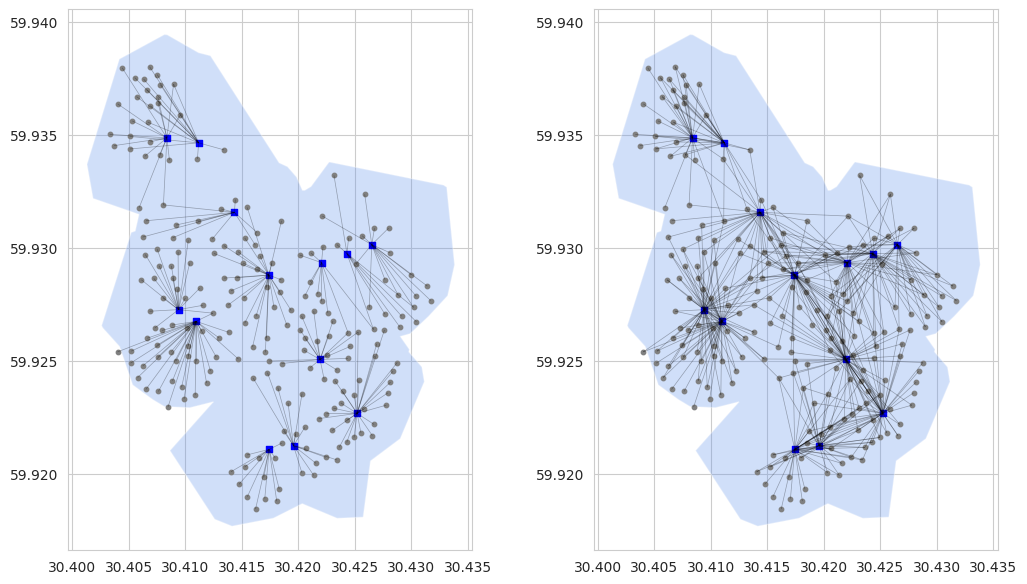

In [79]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
plt.subplots_adjust(wspace=0.3)

plot_component(nodes_ilp, edges_ilp, one_component, ax1)
plot_component(nodes_dcgm, edges_dcgm, one_component, ax2)

plt.show()

In [ ]:
# calculate 600 m walk isohrones for the whole city
components = list(facilities_loc["component"].unique())
zones = []

limit = 600
edge_weight = "length_meter"
crs = 32636
for c in tqdm(components, total=len(ilp_graph_components)):
    isochrones = []
    facilities_zone = facilities_loc[facilities_loc["component"] == c]

    for index, row in facilities_zone.iterrows():
        point = (row["geometry"].xy[0][0], row["geometry"].xy[1][0])
        isochrone = get_accessibility_isochrone(road_network, "walk", point[0], point[1], limit, edge_weight, crs)
        isochrones.append(isochrone)

    df_isochrones = pd.concat(isochrones)
    united_isochrones = gpd.GeoDataFrame({"geometry": [df_isochrones["geometry"].to_crs(32636).unary_union], "component": [c]})
    zones.append(united_isochrones)
    
isochrone_zones = pd.concat(zones).reset_index(drop=True)

##### **Neural net**

In [5]:
import numpy as np
import torch
import random
import json
import os
import seaborn as sns
import scipy
import pandas as pd
import matplotlib.pyplot as plt

from modules import fnn
from modules import gnn
from modules import linear

from tensorboardX import SummaryWriter
from datetime import datetime
from torch_geometric.loader.dataloader import DataLoader
from tqdm.notebook import tqdm
from sklearn import linear_model
from scipy.stats import norm

from modules.dataset import ProvisionSparseDataset_v2
from modules.metrics import cross_validation

import warnings
warnings.filterwarnings('ignore')

# torch.manual_seed(42)
# random.seed(42)
# np.random.seed(42)

In [10]:
dataset_ilp = ProvisionSparseDataset_v2("data/pyg_data/ilp")
dataset_dcgm = ProvisionSparseDataset_v2("data/pyg_data/dcgm/0")

In [3]:
gnn_param ={"input_dim":2, "hidden_dim": 128, "dropout": 0.20}

fnn_param_v0 = {"input_dim": 3, "hidden_dim": 32, "output_dim": 1, "num_layers": 4, "dropout": 0.20}
fnn_param_v1 = {"input_dim": 128 * 2 + 5, "hidden_dim": 64, "output_dim": 1, "num_layers": 4, "dropout": 0.20}

fnn_param_v2_1 = {"input_dim": 128 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 32, "output_dim": 1, "num_layers": 4, 
                "num_layers_norm": 1, "dropout": 0.20}
fnn_param_v2_2 = {"input_dim": 128 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 32, "output_dim": 1, "num_layers": 4, 
                "num_layers_norm": 3, "dropout": 0.20}

models = {
    'log_regression': {'embeddings': None, 'prediction': [linear_model.PoissonRegressor(), None]},
    'U-FNN': {'embeddings': None, 'prediction': [fnn.FNN_v0, fnn_param_v0]},
    'U-GNN': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v1, fnn_param_v1]},
    'DC-GNN_1': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2_1]},
    'DC-GNN_2': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2_2]}
}

In [5]:
def perform_experiments(models, dataset, metric_output_file, iter=1, num_folds=5, shuffle=True):

    if not os.path.isfile(metric_output_file):
        with open(metric_output_file, "w") as outfile:
            init_dict = dict((k, {}) for k in models.keys())
            json.dump(init_dict, outfile)
    else:
        raise FileExistsError(f"File {metric_output_file} already exists.")

    collected_metrics = []
    collected_y = []
    for i in tqdm(range(iter)):

        print(f'Experiment {i}')
        if shuffle: dataset = dataset.shuffle()
        for model_name, model_param in models.items():

            print(f'\n-------------------------{model_name}-------------------------\n')

            param_kwargs = {}
            if model_param['embeddings']:
                param_kwargs['model_type'] = "gnn+fnn"
                param_kwargs['model'] = [model_param['embeddings'][0], model_param['prediction'][0]]
                param_kwargs['model_param'] = [model_param['embeddings'][1], model_param['prediction'][1]]
                param_kwargs['train_func'] = gnn.train_func
                param_kwargs['val_func'] = gnn.val_func
                param_kwargs['epochs'] = 1000
                param_kwargs['device'] = 'cuda'

            elif model_name == 'U-FNN':
                param_kwargs['model_type'] = 'fnn'
                param_kwargs['model'] = [model_param['prediction'][0]]
                param_kwargs['model_param'] = [model_param['prediction'][1]]
                param_kwargs['train_func'] = fnn.train_func
                param_kwargs['val_func'] = fnn.val_func
                param_kwargs['epochs'] = 3000
                param_kwargs['device'] = 'cuda'

            elif model_name == 'log_regression':
                param_kwargs['model_type'] = 'linear'
                param_kwargs['model'] = [model_param['prediction'][0]]
                param_kwargs['model_param'] = [model_param['prediction'][1]]
                param_kwargs['train_func'] = linear.train_func
                param_kwargs['val_func'] = linear.val_func
                param_kwargs['epochs'] = None
                param_kwargs['device'] = 'cpu'
            
            else:
                raise ValueError(f"Model {model_name} is not implemented.")
            
            metrics, y = cross_validation(
                dataset=dataset, 
                num_folds=num_folds, 
                logs=False,
                output=True,
                **param_kwargs
                )
            
            collected_metrics.append(metrics)
            collected_y.append(y)
            with open(metric_output_file, 'r+') as file:
                file_data = json.load(file)
                file_data[model_name].update({str(i): metrics})
                file.seek(0)
                json.dump(file_data, file)

            print(metrics)
    
    return collected_y

In [ ]:
perform_experiments(models, dataset_dcgm, iter=10, metric_output_file="model_output/dcgm/dcgm_0.json")

In [14]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return str(round(m, 3)) + "+/-" + str(round(h,3))

def prepate_metrics_table(path, aggregate=True):

    with open(path, 'r+') as file:
        file_data = json.load(file)

    moodel_metrics = []
    for name, iterations in file_data.items():

        in_sample_loss = []
        out_of_sample_loss = []
        in_sample_CPC = []
        out_of_sample_CPC = []
        iter_num = []

        for iter, metrics in iterations.items():

            in_sample_loss.extend(metrics['in-sample loss'])
            out_of_sample_loss.extend(metrics['out-of-sample loss'])
            in_sample_CPC.extend(metrics['in-sample CPC'])
            out_of_sample_CPC.extend(metrics['out-of-sample CPC'])
            iter_num.extend([_ for _ in range(len(metrics['in-sample loss']))])

        if aggregate:

            moodel_metrics.append(pd.Series({
                'in_sample_loss': mean_confidence_interval(in_sample_loss),
                'in_sample_CPC': mean_confidence_interval(in_sample_CPC),
                'out_of_sample_loss': mean_confidence_interval(out_of_sample_loss),
                'out_of_sample_CPC': mean_confidence_interval(out_of_sample_CPC)
                }, name=name)) 
        
        else:
            moodel_metrics.append(pd.Series({
                'in_sample_loss': in_sample_loss,
                'in_sample_CPC': in_sample_CPC,
                'out_of_sample_loss': out_of_sample_loss,
                'out_of_sample_CPC': out_of_sample_CPC,
            }, name=name).explode())
    
    df = pd.concat(moodel_metrics, axis=1)
    return df

In [17]:
metrics_paths = [
 "model_output/ilp/ilp.json",
 "model_output/dcgm/dcgm_0.json",
 "model_output/dcgm/dcgm_0_5.json",
 "model_output/dcgm/dcgm_1.json",
 "model_output/dcgm/dcgm_1_5.json",
 "model_output/dcgm/dcgm_2.json",
 "model_output/dcgm/dcgm_2_5.json"
 ]

tables = []
for path in metrics_paths:
    df = prepate_metrics_table(path).T
    df = df.reset_index().rename(columns={'index':'metric'})
    df['data'] =  path.split('.')[0].split('/')[-1]
    df = df.set_index([df["data"], df['metric']]).drop(['metric', 'data'], axis=1)
    tables.append(df)

pd.concat(tables)

in_sample_loss  in_sample_CPC out_of_sample_loss  \
data     metric                                                             
ilp      log_regression  -5.898+/-0.408  0.396+/-0.003     -6.891+/-1.187   
         U-FNN           -6.811+/-0.441  0.555+/-0.008     -7.875+/-1.305   
         U-GNN           -7.882+/-0.489  0.671+/-0.019     -8.827+/-1.365   
         DC-GNN_1        -8.397+/-0.485  0.712+/-0.011     -9.418+/-1.427   
         DC-GNN_2        -8.839+/-0.515  0.744+/-0.015     -9.954+/-1.507   
dcgm_0   log_regression  -4.575+/-0.359  0.743+/-0.003     -5.326+/-1.007   
         U-FNN           -4.588+/-0.333  0.747+/-0.003     -5.346+/-1.016   
         U-GNN           -4.993+/-0.363  0.798+/-0.004     -5.724+/-1.014   
         DC-GNN_1         -5.105+/-0.36  0.824+/-0.006     -5.888+/-1.045   
         DC-GNN_2        -5.129+/-0.367  0.833+/-0.009     -5.929+/-1.048   
dcgm_0_5 log_regression  -4.697+/-0.363  0.737+/-0.004     -5.529+/-1.048   
         U-FNN           -4.736+/-0.355  0.746+/-0.003     -5.575+/-1.048   
         U-GNN           -5.111+/-0.358  0.793+/-0.005     -5.918+/-1.072   
         DC-GNN_1         -5.274+/-0.37  0.826+/-0.006     -6.126+/-1.083   
         DC-GNN_2        -5.281+/-0.379   0.831+/-0.01     -6.146+/-1.094   
dcgm_1   log_regression  -4.825+/-0.375  0.709+/-0.003     -5.473+/-1.099   
         U-FNN           -4.966+/-0.371  0.739+/-0.003     -5.626+/-1.105   
         U-GNN           -5.348+/-0.381  0.783+/-0.004     -5.956+/-1.123   
         DC-GNN_1        -5.519+/-0.379  0.816+/-0.007      -6.162+/-1.15   
         DC-GNN_2        -5.564+/-0.406  0.825+/-0.011     -6.212+/-1.156   
dcgm_1_5 log_regression  -4.967+/-0.341  0.674+/-0.003     -5.753+/-1.049   
         U-FNN           -5.245+/-0.347  0.729+/-0.003     -6.049+/-1.071   
         U-GNN            -5.661+/-0.36  0.775+/-0.005     -6.417+/-1.092   
         DC-GNN_1        -5.871+/-0.352   0.81+/-0.009     -6.686+/-1.131   
         DC-GNN_2        -6.016+/-0.363  0.832+/-0.009     -6.864+/-1.146   
dcgm_2   log_regression  -5.052+/-0.405  0.639+/-0.003     -5.846+/-1.123   
         U-FNN            -5.468+/-0.41  0.717+/-0.003     -6.298+/-1.171   
         U-GNN           -5.917+/-0.428  0.764+/-0.008     -6.683+/-1.195   
         DC-GNN_1        -6.149+/-0.457   0.799+/-0.01      -6.933+/-1.21   
         DC-GNN_2         -6.28+/-0.441   0.818+/-0.01      -7.13+/-1.262   
dcgm_2_5 log_regression  -5.081+/-0.371  0.639+/-0.003     -6.144+/-1.188   
         U-FNN           -5.498+/-0.381  0.717+/-0.003     -6.599+/-1.223   
         U-GNN           -5.964+/-0.402  0.765+/-0.007     -7.016+/-1.256   
         DC-GNN_1        -6.202+/-0.384   0.803+/-0.01     -7.337+/-1.315   
         DC-GNN_2        -6.374+/-0.405  0.827+/-0.011      -7.536+/-1.33   

                        out_of_sample_CPC  
data     metric                            
ilp      log_regression     0.398+/-0.005  
         U-FNN              0.554+/-0.011  
         U-GNN                0.66+/-0.02  
         DC-GNN_1           0.701+/-0.013  
         DC-GNN_2           0.734+/-0.019  
dcgm_0   log_regression     0.735+/-0.012  
         U-FNN               0.74+/-0.014  
         U-GNN               0.789+/-0.01  
         DC-GNN_1           0.819+/-0.014  
         DC-GNN_2            0.83+/-0.015  
dcgm_0_5 log_regression     0.733+/-0.009  
         U-FNN               0.743+/-0.01  
         U-GNN              0.783+/-0.011  
         DC-GNN_1             0.82+/-0.01  
         DC-GNN_2           0.827+/-0.013  
dcgm_1   log_regression     0.705+/-0.009  
         U-FNN               0.734+/-0.01  
         U-GNN              0.771+/-0.009  
         DC-GNN_1           0.806+/-0.011  
         DC-GNN_2           0.817+/-0.013  
dcgm_1_5 log_regression     0.671+/-0.006  
         U-FNN              0.726+/-0.008  
         U-GNN              0.765+/-0.007  
         DC-GNN_1           0.803+/-0.012  
         DC-GNN_2           0.8

In [18]:
models = {}

gnn_param ={"input_dim":2, "hidden_dim": 128, "dropout": 0.20}

num_layers=10
for i in range(1, num_layers+1):
    
    fnn_param_v2 = {
        "input_dim": 128 * 2 + 5, 
        "hidden_dim_1": 64, 
        "hidden_dim_2": 32, 
        "output_dim": 1, 
        "num_layers": 4, 
        "num_layers_norm": i, 
        "dropout": 0.20
        }
    
    models[f'DC-GNN_{i}'] = {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2]}

In [19]:
models

{'DC-GNN_1': {'embeddings': [modules.gnn.GNNStack,
   {'input_dim': 2, 'hidden_dim': 128, 'dropout': 0.2}],
  'prediction': [modules.gnn.FNNStack_v2,
   {'input_dim': 261,
    'hidden_dim_1': 64,
    'hidden_dim_2': 32,
    'output_dim': 1,
    'num_layers': 4,
    'num_layers_norm': 1,
    'dropout': 0.2}]},
 'DC-GNN_2': {'embeddings': [modules.gnn.GNNStack,
   {'input_dim': 2, 'hidden_dim': 128, 'dropout': 0.2}],
  'prediction': [modules.gnn.FNNStack_v2,
   {'input_dim': 261,
    'hidden_dim_1': 64,
    'hidden_dim_2': 32,
    'output_dim': 1,
    'num_layers': 4,
    'num_layers_norm': 2,
    'dropout': 0.2}]},
 'DC-GNN_3': {'embeddings': [modules.gnn.GNNStack,
   {'input_dim': 2, 'hidden_dim': 128, 'dropout': 0.2}],
  'prediction': [modules.gnn.FNNStack_v2,
   {'input_dim': 261,
    'hidden_dim_1': 64,
    'hidden_dim_2': 32,
    'output_dim': 1,
    'num_layers': 4,
    'num_layers_norm': 3,
    'dropout': 0.2}]},
 'DC-GNN_4': {'embeddings': [modules.gnn.GNNStack,
   {'input_dim':

In [ ]:
perform_experiments(models, dataset_ilp, iter=10, metric_output_file='model_output/new/ilp/ilp_balancing_layers_10_1.json')

In [28]:
def plot_conf_int(df, fig_name, axs):
    
    df_loss = df.loc['out_of_sample_loss'].astype(float)
    df_r2 = df.loc['out_of_sample_CPC']

    df_loss['iter'] = np.array([[j for i in range(5)] for j in range(10)]).flatten()
    df_r2['iter'] = np.array([[j for i in range(5)] for j in range(10)]).flatten()
    
    df_loss = df_loss.groupby(['iter']).mean().T.stack().droplevel(1)
    df_r2 = df_r2.groupby(['iter']).mean().T.stack().droplevel(1)
    
    sns.lineplot(x=df_loss.index, y=df_loss, ax=axs[0], marker='D')
    sns.lineplot(x=df_r2.index, y=df_r2, ax=axs[1], marker='D')

    axs[0].set_xlabel("Number of steps")
    axs[1].set_xlabel("Number of steps")

    axs[0].set_ylabel("NLL")
    axs[1].set_ylabel("CPC")

    axs[0].set_xticks(range(1, 11))
    axs[1].set_xticks(range(1, 11))

    plt.savefig(fig_name, dpi=300)

    fig.suptitle("The dependence of the out-of-sample performance of the C-GNN_DGM on the number of balancing steps.")


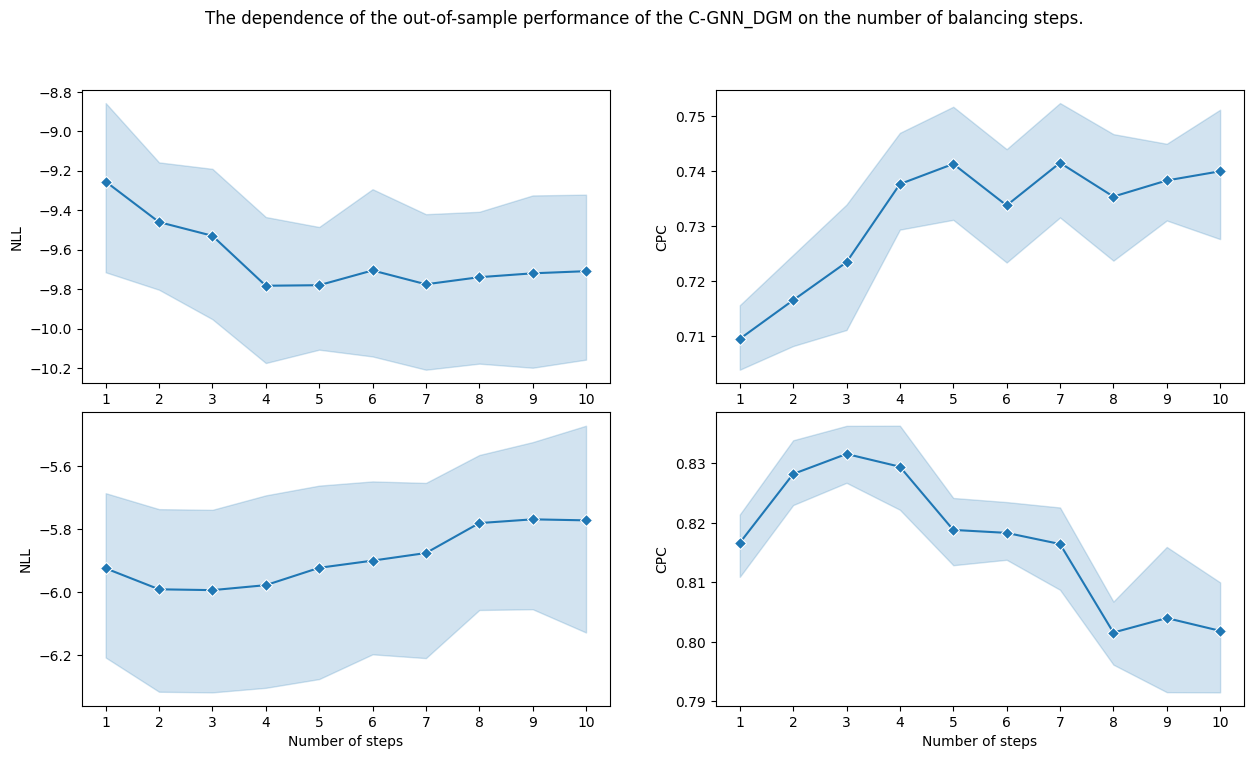

In [30]:
fig = plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.1)
plt.subplots_adjust(wspace=0.2)
gs = fig.add_gridspec(2,2)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
]

ilp_balancing_layers = prepate_metrics_table('model_output/ilp/ilp_balancing_layers.json', aggregate=False)
ilp_balancing_layers.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plot_conf_int(ilp_balancing_layers, 'ilp_balancing_layers.png', axs[:2])

dcgm_balancing_layers = prepate_metrics_table('/media/a/e/mm_24/facility_provision/model_output/dcgm/dcgm_balancing_layers.json', aggregate=False)
dcgm_balancing_layers.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plot_conf_int(dcgm_balancing_layers, 'dcgm_balancing_layers.png', axs[2:])

plt.show()

In [8]:
gnn_param ={"input_dim":2, "hidden_dim": 128, "dropout": 0.20}

fnn_param_v1 = {"input_dim": 128 * 2 + 5, "hidden_dim": 64, "output_dim": 1, "num_layers": 4, "dropout": 0.20}
fnn_param_v2 = {"input_dim": 128 * 2 + 5, "hidden_dim_1": 64, "hidden_dim_2": 32, "output_dim": 1, "num_layers": 4, 
                "num_layers_norm": 3, "dropout": 0.20}

dc_gnn_model = {
    'DC-GNN_3': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v2, fnn_param_v2]}
}

gnn_model = {'U-GNN': {'embeddings': [gnn.GNNStack, gnn_param], 'prediction': [gnn.FNNStack_v1, fnn_param_v1]}}

In [ ]:
ilp_dc_gnn_y = perform_experiments(dc_gnn_model, dataset_ilp, iter=20, shuffle=False, metric_output_file='model_output/ilp/ilp_dc_gnn_20.json')
ilp_gnn_y = perform_experiments(gnn_model, dataset_ilp, iter=20, shuffle=False, metric_output_file='model_output/ilp/ilp_gnn_20.json')

In [ ]:
dcgm_dc_gnn_y = perform_experiments(dc_gnn_model, dataset_dcgm, iter=20, shuffle=False, metric_output_file='model_output/dcgm/dcgm_dc_gnn_20_1.json')
dcgm_gnn_y = perform_experiments(gnn_model, dataset_dcgm, iter=20, shuffle=False, metric_output_file='model_output/dcgm/dcgm_gnn_20_1.json')

In [2]:
import pickle
with open('model_output/ilp/ilp_dc_gnn_y_20.pickle', 'rb') as handle:
    ilp_dc_gnn_y = pickle.load(handle)
with open('model_output/ilp/ilp_gnn_y_20.pickle', 'rb') as handle:
    ilp_gnn_y = pickle.load(handle)

In [4]:
import pickle
with open('model_output/dcgm/dcgm_dc_gnn_y_20.pickle', 'rb') as handle:
    dcgm_dc_gnn_y = pickle.load(handle)
with open('model_output/dcgm/dcgm_gnn_y_20.pickle', 'rb') as handle:
    dcgm_gnn_y = pickle.load(handle)

In [19]:
def get_bootstrap(data_column_1, data_column_2, iterations=15000, statistic=np.mean, sign_level=0.05, plot=None, type='two-side'):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data, samples_1_a, samples_2_a = [], [], []

    # Bootstrap sampling
    for _ in tqdm(range(iterations)):
        sample_1 = data_column_1.sample(boot_len, replace=True).values
        sample_2 = data_column_2.sample(boot_len, replace=True).values
        boot_data.append(statistic(sample_1 - sample_2))
        samples_1_a.append(np.mean(sample_1))
        samples_2_a.append(np.mean(sample_2))

    # Calculate quantiles
    quants = pd.DataFrame(boot_data).quantile([sign_level / 2, 1 - sign_level / 2])

    # Calculate p-values
    boot_mean, boot_std = np.mean(boot_data), np.std(boot_data)
    p_1 = norm.cdf(0, boot_mean, boot_std)
    p_2 = norm.cdf(0, -boot_mean, boot_std)

    if type == 'greater':
        p_value = p_1
    elif type == "less":
        p_value = p_2
    else:
        p_value = min(p_1, p_2) * 2

    return mean_confidence_interval(boot_data), p_value

In [31]:
from sklearn.metrics import r2_score

def get_provision_plots(y_hat_baseline_lst, y_hat_new_lst, dataset, fig_name):
    

    y_sum_i_lst = []
    y_sum_i_hat_baseline_lst = []
    y_sum_j_hat_baseline_lst = []
    y_sum_i_hat_new_lst = []
    y_sum_j_hat_new_lst = []

    for y_hat_baseline, y_hat_new in zip(y_hat_baseline_lst, y_hat_new_lst):

        y_hat_new = torch.round(torch.concat(y_hat_new)).to('cpu')
        y_hat_baseline = torch.round(torch.concat(y_hat_baseline)).to('cpu')
        dataset_loader = next(iter(DataLoader(dataset, batch_size=len(dataset))))

        x_s = dataset_loader.x_s
        x_t = dataset_loader.x_t
        edge_index = dataset_loader.edge_index
        y = dataset_loader.y

        mask = (x_s[edge_index[0], 1] != 0) & (x_t[edge_index[1], 1] != 0)
        y = y[mask]
        edge_index = edge_index[:, mask]


        y_sum_i = torch.zeros_like(x_s[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y)
        y_sum_i_lst.extend(y_sum_i)

        y_sum_i_hat_baseline = torch.zeros_like(x_s[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y_hat_baseline)
        y_sum_j_hat_baseline = torch.zeros_like(x_t[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y_hat_baseline)

        y_sum_i_hat_baseline_lst.extend(y_sum_i_hat_baseline)
        y_sum_j_hat_baseline_lst.extend(y_sum_j_hat_baseline)

        y_sum_i_hat_new = torch.zeros_like(x_s[:, 1], dtype=y.dtype).index_add_(0, edge_index[0], y_hat_new)
        y_sum_j_hat_new = torch.zeros_like(x_t[:, 1], dtype=y.dtype).index_add_(0, edge_index[1], y_hat_new)

        y_sum_i_hat_new_lst.extend(y_sum_i_hat_new)
        y_sum_j_hat_new_lst.extend(y_sum_j_hat_new)
    

    r2_baseline = round(r2_score(y_sum_i_lst, y_sum_i_hat_baseline_lst), 3)
    r2_new = round(r2_score(y_sum_i_lst, y_sum_i_hat_new_lst), 3)

    fig = plt.figure(figsize=(16, 9))
    plt.subplots_adjust(wspace=0.3)
    plt.subplots_adjust(hspace=0.3)
    gs = fig.add_gridspec(2,3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    xs = np.array(x_s[:, 1].repeat(len(y_hat_baseline_lst)))
    xs_baseline_diff = y_sum_i_hat_baseline_lst - xs
    xs_new_diff = y_sum_i_hat_new_lst - xs
    
    xs_baseline_diff = xs_baseline_diff[xs_baseline_diff > 0]
    xs_new_diff = xs_new_diff[xs_new_diff > 0]

    bins = np.linspace(0, max([max(xs_baseline_diff), max(xs_new_diff)]), 50)
    ax3.hist(
        xs_baseline_diff, 
        bins=bins,
        color='silver', 
        alpha=0.7, 
        edgecolor='none', 
        stacked=True, 
        label='GNN-DGM (MAE {:.3f})'.format(np.mean(xs_baseline_diff)), 
        log=True
        )
    
    ax3.hist(
        xs_new_diff, 
        bins=bins, 
        edgecolor='none', 
        stacked=True, 
        alpha=0.4, 
        label='C-GNN-DGM (MAE {:.3f})'.format(np.mean(xs_new_diff)), 
        log=True
        )
    
    ttest = scipy.stats.ttest_ind(xs_baseline_diff, xs_new_diff, equal_var=False, alternative='greater')
    error_mean = np.mean(xs_baseline_diff) - np.mean(xs_new_diff)
    boot_mean, boot_p_value = get_bootstrap(pd.Series(xs_baseline_diff), pd.Series(xs_new_diff), type='greater')
    print("Difference between error means in in-going flows:")
    print("Welch’s t-test: mean {:.3f}, p_value {:.3f}".format(error_mean, ttest.pvalue))
    print("Bootstrapping test: bootstap mean {}, p_value {:.3f}".format(boot_mean, boot_p_value))

    xt = np.array(x_t[:, 1].repeat(len(y_hat_baseline_lst)))
    xt_baseline_diff = y_sum_j_hat_baseline_lst - xt
    xt_new_diff = y_sum_j_hat_new_lst - xt

    xt_baseline_diff = xt_baseline_diff[xt_baseline_diff > 0]
    xt_new_diff = xt_new_diff[xt_new_diff > 0]

    bins = np.linspace(0, max([max(xt_baseline_diff), max(xt_new_diff)]), 70)
    ax2.hist(
        xt_baseline_diff, 
        bins=bins, 
        color='silver', 
        alpha=0.7, 
        edgecolor='none', 
        stacked=True, 
        label='GNN-DGM (MAE {:.3f})'.format(np.mean(xt_baseline_diff)), 
        log=True
        )
    
    ax2.hist(
        xt_new_diff, 
        bins=bins, 
        edgecolor='none', 
        stacked=True, 
        alpha=0.4, 
        label='C-GNN-DGM (MAE {:.3f})'.format(np.mean(xt_new_diff)), 
        log=True
        )
    
    ttest = scipy.stats.ttest_ind(xt_baseline_diff, xt_new_diff, equal_var=False, alternative='greater')
    error_mean = np.mean(xt_baseline_diff) - np.mean(xt_new_diff)
    boot_mean, boot_p_value = get_bootstrap(pd.Series(xt_baseline_diff), pd.Series(xt_new_diff), type='greater')
    print("Difference between error means in in-going flows:")
    print("Welch’s t-test: mean {:.3f}, p_value {:.3f}".format(error_mean, ttest.pvalue))
    print("Bootstrapping test: bootstap mean {}, p_value {:.3f}".format(boot_mean, boot_p_value))

    ax1.scatter(
        y_sum_i_lst, 
        y_sum_i_hat_baseline_lst, 
        s=10, 
        alpha=0.6, 
        c="silver", 
        label=f'GNN-DGM R2 = {r2_baseline}', 
        marker='x'
        )
    
    ax1.scatter(
        y_sum_i_lst, 
        y_sum_i_hat_new_lst, 
        s=1, 
        alpha=0.6, 
        label=f'C-GNN-DGM R2 = {r2_new}'
        )

    best_fit = np.max([y_sum_i_hat_baseline_lst, y_sum_i_hat_new_lst, y_sum_i_lst])
    ax1.plot([0, best_fit], [0, best_fit], linewidth=0.7, c="black", linestyle='--')

    ax3.set_title("The distribution of out-going flows’ cumulative error", pad=20)
    ax3.set_xlabel("Absolute error in cumulative out-going flows")
    ax3.set_ylabel("Number of buildings")
    ax3.legend(loc='upper right')

    ax2.set_title("The distribution of in-going flows’ cumulative error", pad=20)
    ax2.set_xlabel("Absolute error in cumulative in-going flows")
    ax2.set_ylabel("Number of kindergartens")
    ax2.legend(loc='upper right')

    ax1.set_title("Provision assessment (predicted vs observed)", pad=20)
    ax1.set_xlabel("Provided population (observed)")
    ax1.set_ylabel("Provided population (predicted)")
    ax1.set_xlim([0, best_fit])
    ax1.legend()
    
    plt.savefig(fig_name, dpi=300)
    plt.show()

  0%|          | 0/15000 [00:00<?, ?it/s]

Difference between error means in in-going flows:
Welch’s t-test: mean 1.186, p_value 0.000
Bootstrapping test: bootstap mean 1.186+/-0.0, p_value 0.000


  0%|          | 0/15000 [00:00<?, ?it/s]

Difference between error means in in-going flows:
Welch’s t-test: mean 31.598, p_value 0.000
Bootstrapping test: bootstap mean 31.587+/-0.013, p_value 0.000


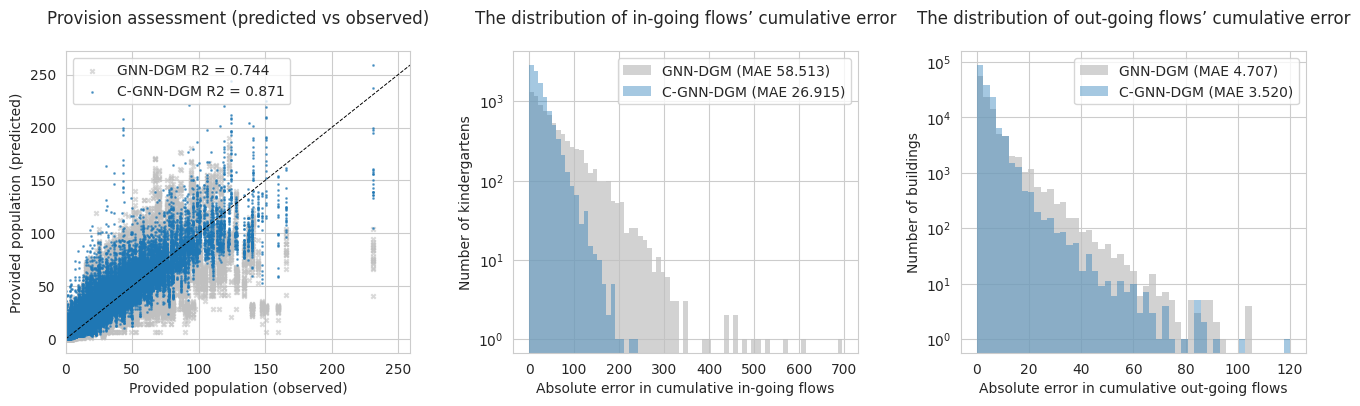

In [32]:
a = get_provision_plots(dcgm_gnn_y, dcgm_dc_gnn_y, dataset_dcgm, fig_name="dataset_dcgm_error_hist.png")

  0%|          | 0/15000 [00:00<?, ?it/s]

Difference between error means in in-going flows:
Welch’s t-test: mean 0.187, p_value 0.000
Bootstrapping test: bootstap mean 0.188+/-0.001, p_value 0.000


  0%|          | 0/15000 [00:00<?, ?it/s]

Difference between error means in in-going flows:
Welch’s t-test: mean 27.509, p_value 0.000
Bootstrapping test: bootstap mean 27.495+/-0.015, p_value 0.000


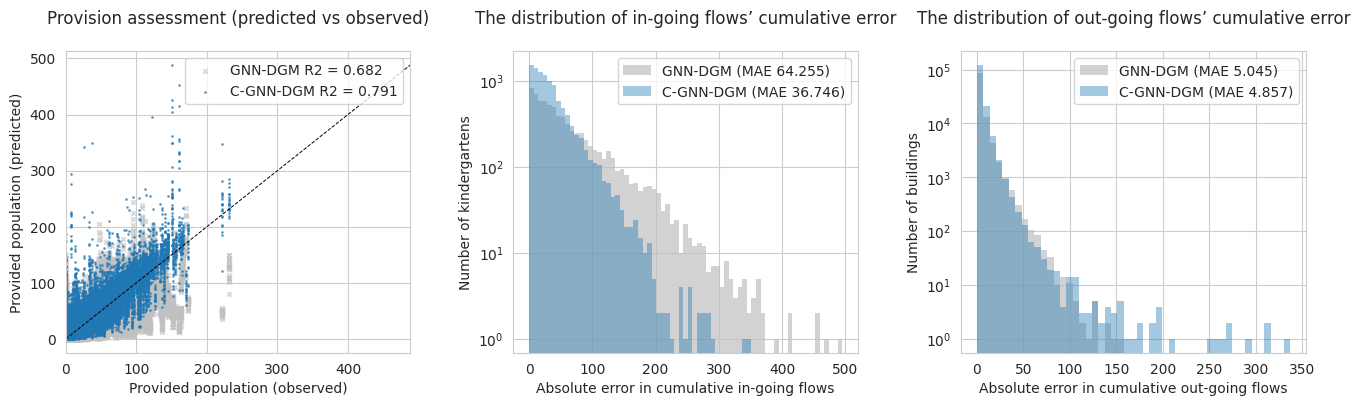

In [33]:
get_provision_plots(ilp_gnn_y, ilp_dc_gnn_y, dataset_ilp, fig_name="dataset_ilp_error_hist.png")